In [1]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.nonlinear_stokes.nonlinear_stokes_common import (
    plot_solution,
    loss_fn,
    fenics_to_jax,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
)

from src.nonlinear_stokes.nonlinear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

In [2]:
args = parser.parse_args("")
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

In [3]:
params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

/usr/local/anaconda3/envs/dvvf/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3000.803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [4]:
u_p = solve_fenics(params)

In [5]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 128, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

In [6]:
jax_fn = fenics_to_jax(u_p)

taylor = SecondOrderTaylorLookup(u_p, all_points)

In [7]:
defined_walls = np.array([x for x in points_on_walls if is_defined(x, u_p)])
defined_holes = np.array([x for x in points_on_holes if is_defined(x, u_p)])

u_p.set_allow_extrapolation(True)
u_inlet = np.array([u_p(x) for x in points_on_inlet])
u_walls = np.array([u_p(x) for x in points_on_walls])
u_holes = np.array([u_p(x) for x in points_on_holes])
u_domain = np.array([u_p(x) for x in points_in_domain])
u_p.set_allow_extrapolation(False)

u_defined_walls = np.array([u_p(x) for x in defined_walls])
u_defined_holes = np.array([u_p(x) for x in defined_holes])

In [8]:
def plot_mesh(u_p):
    fa.plot(
        u_p.function_space().mesh()
    )

def measure_fn_error(approx_fn, points, true_vals):
    error = np.linalg.norm(approx_fn(points) - true_vals, axis=1)
    rel_error = error / np.linalg.norm(true_vals, axis=1)
    print("mean abs err: ", np.mean(error))
    print("mean rel err: ", np.mean(rel_error))

    plt.figure(figsize=(4, 4))
    plt.title("Abs error distribution")
    plt.plot(np.arange(len(error))/len(error), np.sort(error))

    plt.figure(figsize=(4, 4))
    plt.title("Rel error distribution")
    plt.plot(np.arange(len(error))/len(error), np.sort(rel_error))

    plt.figure(figsize=(4, 4))
    plt.title("abs err")
    plot_mesh(u_p)
    clrs = plt.scatter(points[:, 0], points[:, 1], c=error)
    plt.colorbar(clrs)

    plt.figure(figsize=(4, 4))
    plt.title("rel err")
    plot_mesh(u_p)
    clrs = plt.scatter(points[:, 0], points[:, 1], c=rel_error)
    plt.colorbar(clrs)

    plt.show()

# jax_to_fenics (nearest neighbor interpolation)

mean abs err:  353.53702
mean rel err:  0.01198720743257495


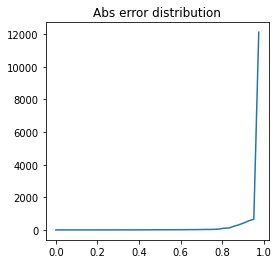

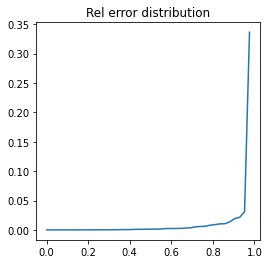

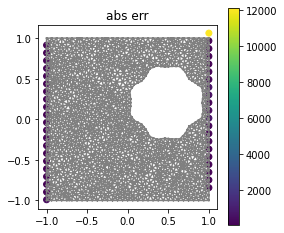

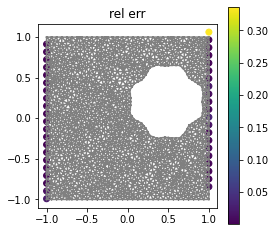

In [9]:
measure_fn_error(jax_fn, points_on_inlet, u_inlet)

In [10]:
points_on_inlet

DeviceArray([[-1.        , -0.9915546 ],
             [-1.        , -0.8963165 ],
             [-1.        , -0.80107844],
             [-1.        , -0.70584035],
             [-1.        , -0.61060226],
             [-1.        , -0.51536417],
             [-1.        , -0.42012602],
             [-1.        , -0.32488787],
             [-1.        , -0.22964984],
             [-1.        , -0.1344117 ],
             [-1.        , -0.03917366],
             [-1.        ,  0.05606452],
             [-1.        ,  0.1513026 ],
             [-1.        ,  0.2465407 ],
             [-1.        ,  0.34177878],
             [-1.        ,  0.43701687],
             [-1.        ,  0.53225493],
             [-1.        ,  0.627493  ],
             [-1.        ,  0.7227311 ],
             [-1.        ,  0.8179692 ],
             [-1.        ,  0.9132073 ],
             [ 1.        ,  1.0617014 ],
             [ 1.        ,  0.9664633 ],
             [ 1.        ,  0.87122524],
             [ 1

mean abs err:  20.609385
mean rel err:  0.005594335620238347


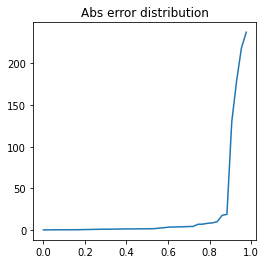

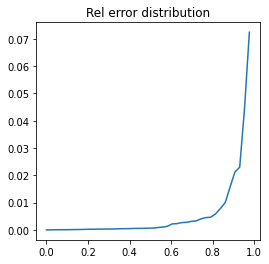

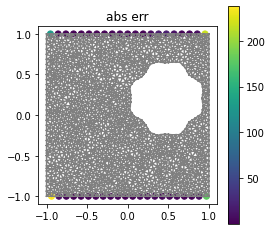

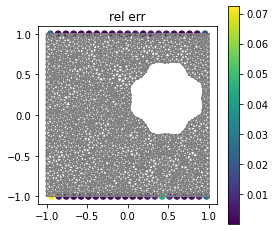

In [11]:
measure_fn_error(jax_fn, points_on_walls, u_walls)

mean abs err:  160.52696
mean rel err:  0.05530731852247678


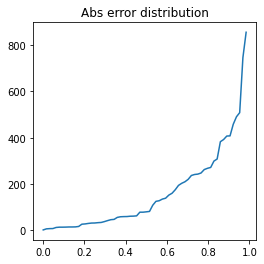

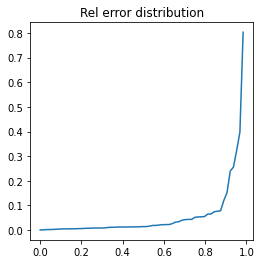

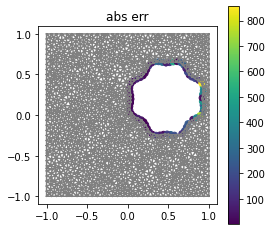

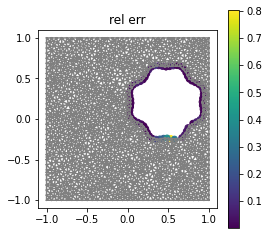

In [12]:
measure_fn_error(jax_fn, points_on_holes, u_holes)

mean abs err:  39.72711
mean rel err:  0.01265419204748976


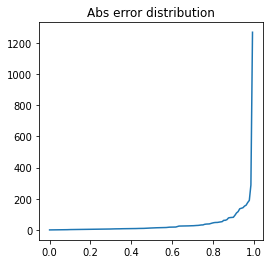

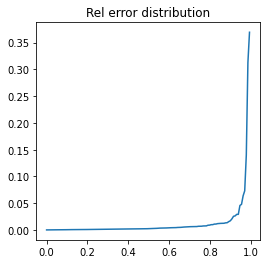

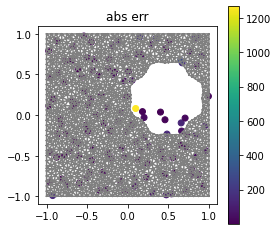

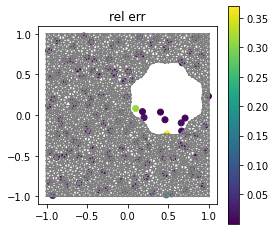

In [13]:
measure_fn_error(jax_fn, points_in_domain, u_domain)

mean abs err:  20.609385
mean rel err:  0.005594335620238347


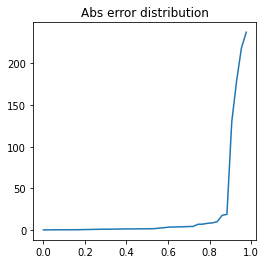

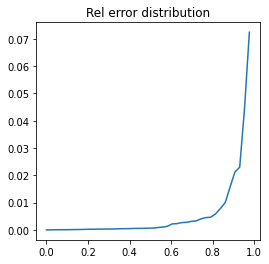

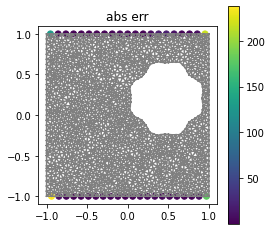

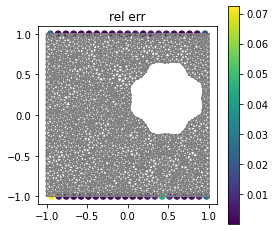

In [14]:
measure_fn_error(jax_fn, defined_walls, u_defined_walls)

mean abs err:  184.84813
mean rel err:  0.04570519851520982


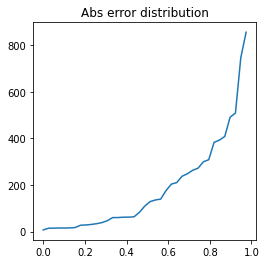

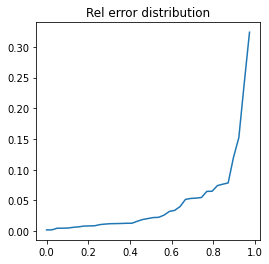

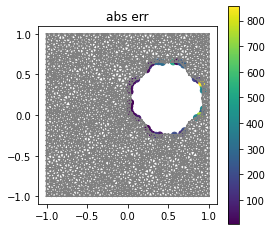

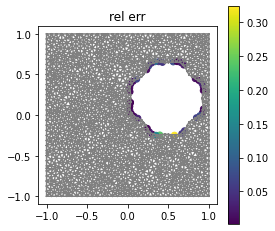

In [15]:
measure_fn_error(jax_fn, defined_holes, u_defined_holes)

# taylor expansion

inds shape:  (42, 1)
inds:  [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]
 [25]
 [26]
 [27]
 [28]
 [29]
 [30]
 [31]
 [32]
 [33]
 [34]
 [35]
 [36]
 [37]
 [38]
 [39]
 [40]
 [41]]
mean abs err:  0.0
mean rel err:  0.0


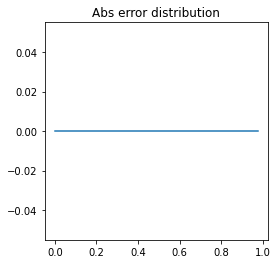

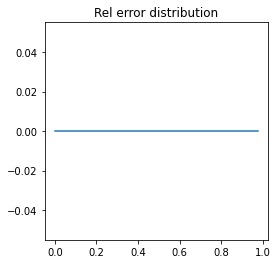

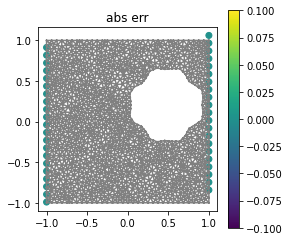

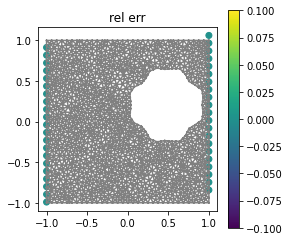

In [16]:
measure_fn_error(taylor, points_on_inlet, u_inlet)

inds shape:  (43, 1)
inds:  [[42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [49]
 [50]
 [51]
 [52]
 [53]
 [54]
 [55]
 [56]
 [57]
 [58]
 [59]
 [60]
 [61]
 [62]
 [63]
 [64]
 [65]
 [66]
 [67]
 [68]
 [69]
 [70]
 [71]
 [72]
 [73]
 [74]
 [75]
 [76]
 [77]
 [78]
 [79]
 [80]
 [81]
 [82]
 [83]
 [84]]
mean abs err:  0.0
mean rel err:  0.0


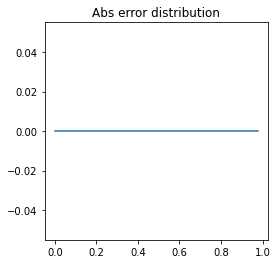

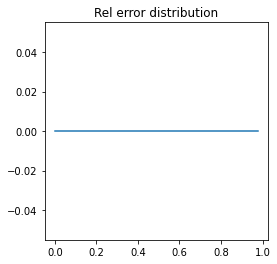

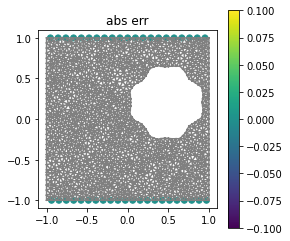

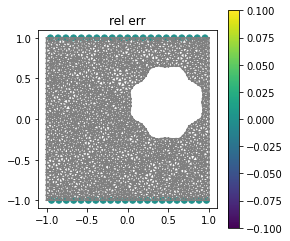

In [17]:
measure_fn_error(taylor, points_on_walls, u_walls)

inds shape:  (64, 1)
inds:  [[ 85]
 [ 86]
 [ 87]
 [ 88]
 [ 89]
 [ 90]
 [ 91]
 [ 92]
 [ 93]
 [ 94]
 [ 95]
 [ 96]
 [ 97]
 [ 98]
 [ 99]
 [100]
 [101]
 [102]
 [103]
 [104]
 [105]
 [106]
 [107]
 [108]
 [109]
 [110]
 [111]
 [112]
 [113]
 [114]
 [115]
 [116]
 [117]
 [118]
 [119]
 [120]
 [121]
 [122]
 [123]
 [124]
 [125]
 [126]
 [127]
 [128]
 [129]
 [130]
 [131]
 [132]
 [133]
 [134]
 [135]
 [136]
 [137]
 [138]
 [139]
 [140]
 [141]
 [106]
 [143]
 [144]
 [145]
 [146]
 [109]
 [148]]
mean abs err:  0.0
mean rel err:  0.0


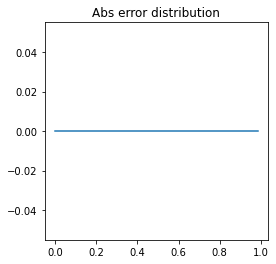

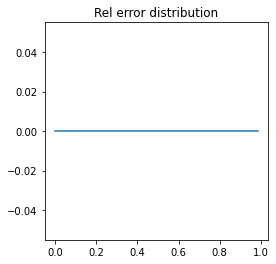

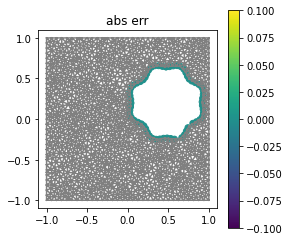

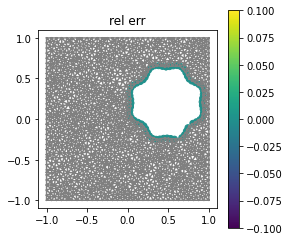

In [18]:
measure_fn_error(taylor, points_on_holes, u_holes)

inds shape:  (128, 1)
inds:  [[149]
 [150]
 [151]
 [152]
 [153]
 [154]
 [155]
 [156]
 [157]
 [158]
 [159]
 [160]
 [161]
 [162]
 [163]
 [164]
 [165]
 [166]
 [167]
 [168]
 [169]
 [170]
 [171]
 [172]
 [173]
 [174]
 [175]
 [176]
 [177]
 [178]
 [179]
 [180]
 [181]
 [182]
 [183]
 [184]
 [185]
 [186]
 [187]
 [188]
 [189]
 [190]
 [191]
 [192]
 [193]
 [194]
 [195]
 [196]
 [197]
 [198]
 [199]
 [200]
 [201]
 [202]
 [203]
 [204]
 [205]
 [206]
 [207]
 [208]
 [209]
 [210]
 [211]
 [212]
 [213]
 [214]
 [215]
 [216]
 [217]
 [218]
 [219]
 [220]
 [221]
 [222]
 [223]
 [224]
 [225]
 [226]
 [227]
 [228]
 [229]
 [230]
 [231]
 [232]
 [233]
 [234]
 [235]
 [236]
 [237]
 [238]
 [239]
 [240]
 [241]
 [242]
 [243]
 [244]
 [245]
 [246]
 [247]
 [248]
 [249]
 [250]
 [251]
 [252]
 [253]
 [254]
 [255]
 [256]
 [257]
 [258]
 [259]
 [260]
 [261]
 [262]
 [263]
 [264]
 [265]
 [266]
 [267]
 [268]
 [269]
 [270]
 [271]
 [272]
 [273]
 [274]
 [275]
 [276]]
mean abs err:  0.0
mean rel err:  0.0


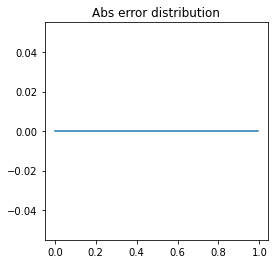

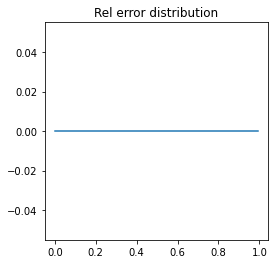

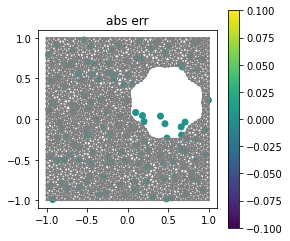

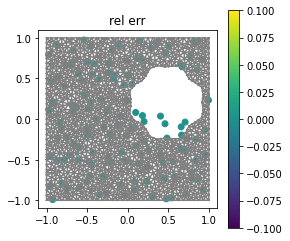

In [19]:
measure_fn_error(taylor, points_in_domain, u_domain)

inds shape:  (43, 1)
inds:  [[42]
 [43]
 [44]
 [45]
 [46]
 [47]
 [48]
 [49]
 [50]
 [51]
 [52]
 [53]
 [54]
 [55]
 [56]
 [57]
 [58]
 [59]
 [60]
 [61]
 [62]
 [63]
 [64]
 [65]
 [66]
 [67]
 [68]
 [69]
 [70]
 [71]
 [72]
 [73]
 [74]
 [75]
 [76]
 [77]
 [78]
 [79]
 [80]
 [81]
 [82]
 [83]
 [84]]
mean abs err:  0.0
mean rel err:  0.0


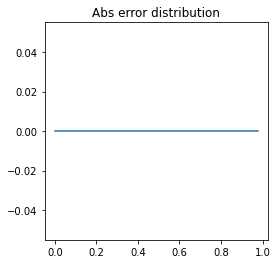

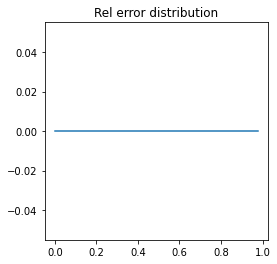

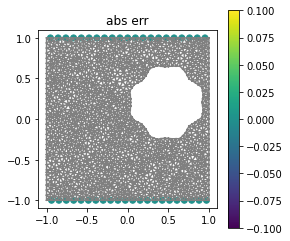

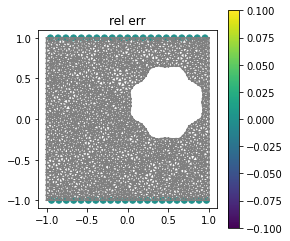

In [20]:
measure_fn_error(taylor, defined_walls, u_defined_walls)

inds shape:  (39, 1)
inds:  [[ 85]
 [ 88]
 [ 89]
 [ 93]
 [ 94]
 [ 95]
 [ 97]
 [101]
 [102]
 [103]
 [104]
 [105]
 [108]
 [109]
 [110]
 [112]
 [116]
 [118]
 [119]
 [120]
 [122]
 [124]
 [125]
 [126]
 [129]
 [131]
 [133]
 [134]
 [135]
 [136]
 [138]
 [139]
 [140]
 [141]
 [143]
 [145]
 [146]
 [109]
 [148]]
mean abs err:  0.0
mean rel err:  0.0


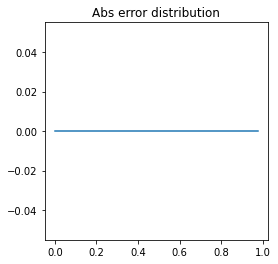

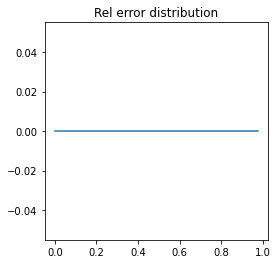

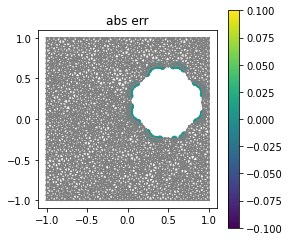

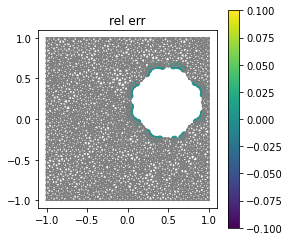

In [21]:
measure_fn_error(taylor, defined_holes, u_defined_holes)